In [1]:
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor


from trading_envs import SimpleTradingEnv, TradingEnv
from logger import TrainingLoggerCallback
from data_and_plots import generate_sine_wave, training_plot, results_plot
from helper import predict_data_env
from sklearn.preprocessing import MinMaxScaler
import torch
import random

In [2]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# ziarno dla NumPy
np.random.seed(42)

# ziarno dla standardowego generatora liczb losowych Pythona
random.seed(42)

In [4]:
prices = generate_sine_wave(seed=42)
prices = prices.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)
scaled_prices = scaled_prices.astype(np.float32)

original_prices = scaler.inverse_transform(scaled_prices)
scaled_prices = scaled_prices.flatten()
original_prices = original_prices.flatten()
# plot_sin(scaled_prices)

# plot_sin(original_prices)
# prices

Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 400      |
|    ep_rew_mean     | 70       |
| time/              |          |
|    fps             | 686      |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 400      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 76          |
| time/                   |             |
|    fps                  | 528         |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 800         |
| train/                  |             |
|    approx_kl            | 0.047910936 |
|    clip_fraction        | 0.537       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.06       |
|    explained_vari

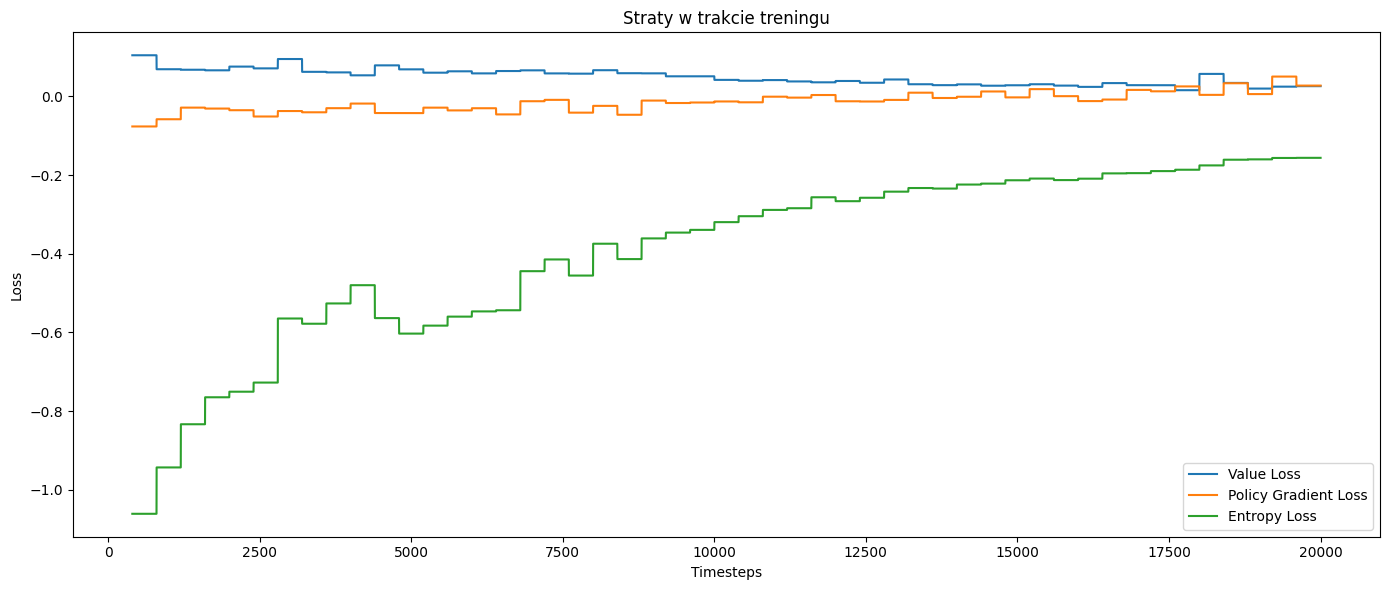

In [29]:
# Stwórz instancję środowiska
env_agent = SimpleTradingEnv(scaled_prices)
env_agent = Monitor(env_agent)

# Sprawdź zgodność środowiska ze Stable-Baselines3
check_env(env_agent)

logger_callback = TrainingLoggerCallback()
# Tworzenie modelu PPO
model_agent = PPO(
    "MlpPolicy",
    env_agent,
    # tensorboard_log="./ppo_trading_tensorboard/",  # <- folder z logami
    policy_kwargs=dict(
        net_arch=[
            128,
            128,
        ]
    ),
    #   learning_rate=0.0005,        # domyślnie 3e-4
    n_steps=400,  # liczba kroków zanim agent zrobi aktualizację
    # batch_size=32,               # batch size do uczenia
    # n_epochs=10,                 # ile razy przebiega po danych przy każdej aktualizacji
    gamma=0.3,  # współczynnik dyskontujący nagrody
    # gae_lambda=0.95,             # współczynnik GAE
    # clip_range=0.2,              # zakres klipu PPO (stabilizacja treningu)
    # ent_coef=0.8,                # zachęta do eksploracji
    verbose=1,
)

# Trening modelu
model_agent.learn(total_timesteps=20_000, callback=logger_callback)


training_plot(logger_callback=logger_callback)

In [27]:
env_predict = predict_data_env(
    env=SimpleTradingEnv, data=scaled_prices, agent=model_agent
)

Krok: 1, Cena: 0.53, Gotówka: 99.50, Akcje: 1, Wartość portfela: 100.03
Krok: 2, Cena: 0.56, Gotówka: 98.97, Akcje: 2, Wartość portfela: 100.10
Krok: 3, Cena: 0.59, Gotówka: 98.41, Akcje: 3, Wartość portfela: 100.19
Krok: 4, Cena: 0.62, Gotówka: 97.81, Akcje: 4, Wartość portfela: 100.29
Krok: 5, Cena: 0.65, Gotówka: 98.43, Akcje: 3, Wartość portfela: 100.39
Krok: 6, Cena: 0.68, Gotówka: 99.08, Akcje: 2, Wartość portfela: 100.45
Krok: 7, Cena: 0.71, Gotówka: 99.77, Akcje: 1, Wartość portfela: 100.48
Krok: 8, Cena: 0.74, Gotówka: 100.48, Akcje: 0, Wartość portfela: 100.48
Krok: 9, Cena: 0.76, Gotówka: 100.48, Akcje: 0, Wartość portfela: 100.48
Krok: 10, Cena: 0.79, Gotówka: 100.48, Akcje: 0, Wartość portfela: 100.48
Krok: 11, Cena: 0.82, Gotówka: 100.48, Akcje: 0, Wartość portfela: 100.48
Krok: 12, Cena: 0.84, Gotówka: 100.48, Akcje: 0, Wartość portfela: 100.48
Krok: 13, Cena: 0.86, Gotówka: 100.48, Akcje: 0, Wartość portfela: 100.48
Krok: 14, Cena: 0.88, Gotówka: 100.48, Akcje: 0, Warto

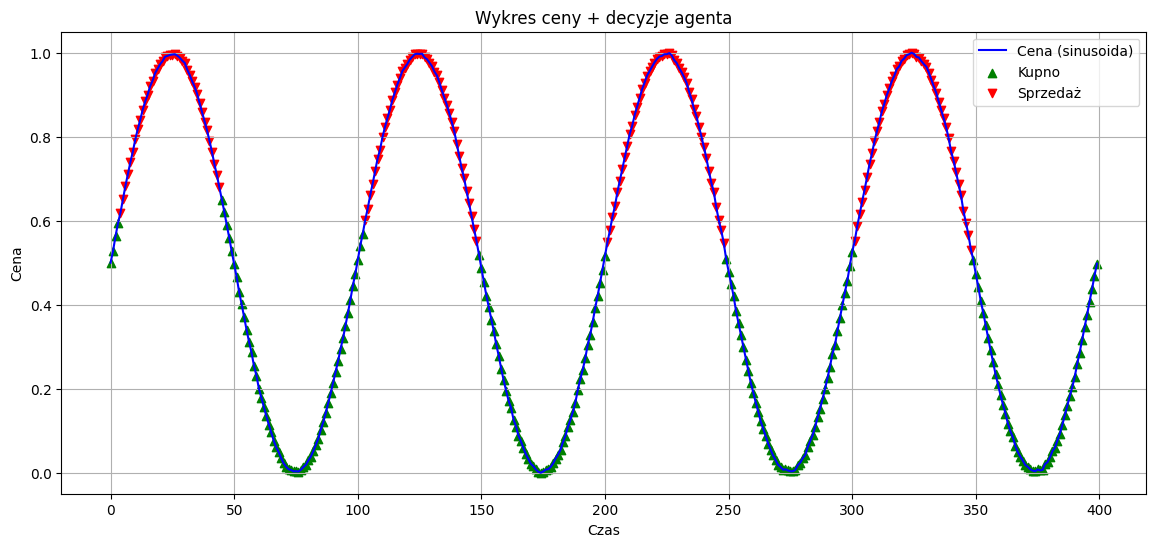

In [28]:
results_plot(env_predict=env_predict, prices=scaled_prices)

Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 399      |
|    ep_rew_mean     | 15.5     |
| time/              |          |
|    fps             | 518      |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 400      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 399         |
|    ep_rew_mean          | -12.8       |
| time/                   |             |
|    fps                  | 453         |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 800         |
| train/                  |             |
|    approx_kl            | 0.011150875 |
|    clip_fraction        | 0.178       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_vari

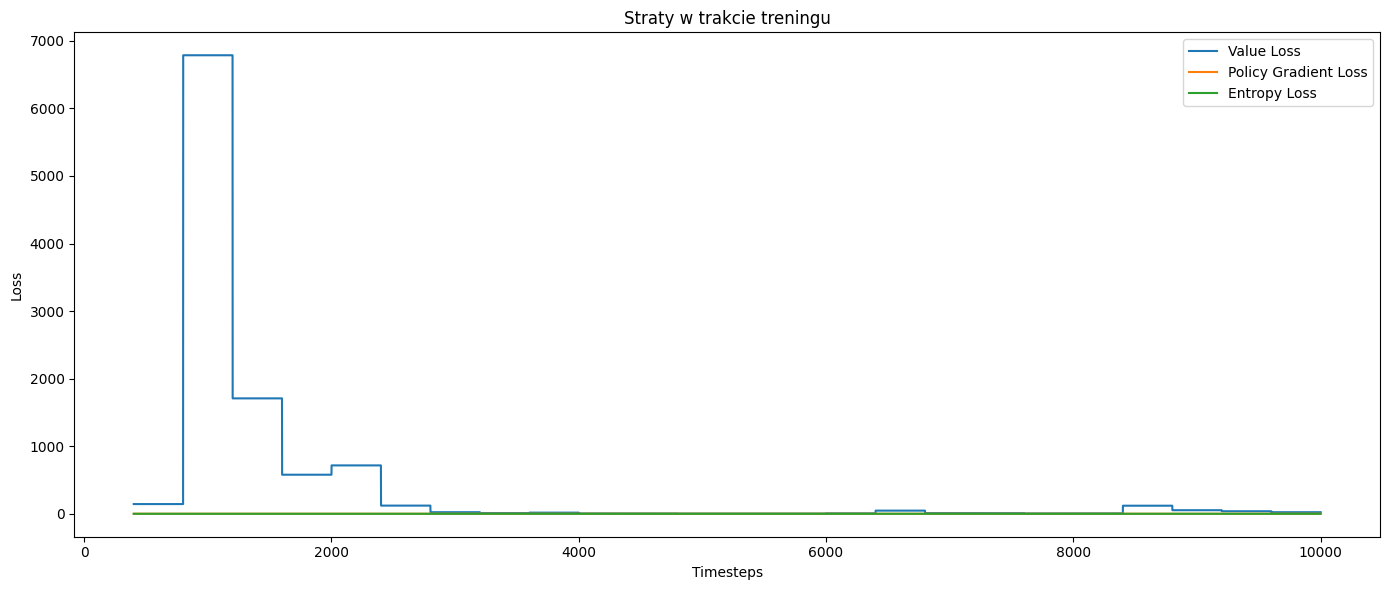

In [14]:
env_agent = TradingEnv(prices)
env_agent = Monitor(env_agent)

# Sprawdź zgodność środowiska ze Stable-Baselines3
check_env(env_agent)

logger_callback = TrainingLoggerCallback()
# Tworzenie modelu PPO
model_agent = PPO(
    "MlpPolicy",
    env_agent,
    # tensorboard_log="./ppo_trading_tensorboard/",  # <- folder z logami
    policy_kwargs=dict(net_arch=[1024, 1024, 128]),
    # learning_rate=5e-4,        # domyślnie 3e-4
    n_steps=400,  # liczba kroków zanim agent zrobi aktualizację
    # batch_size=32,               # batch size do uczenia
    # n_epochs=10,                 # ile razy przebiega po danych przy każdej aktualizacji
    # gamma=0.50,                  # współczynnik dyskontujący nagrody
    # gae_lambda=0.95,             # współczynnik GAE
    # clip_range=0.2,              # zakres klipu PPO (stabilizacja treningu)
    # ent_coef=0.01,                # zachęta do eksploracji
    verbose=1,
)

# Trening modelu
model_agent.learn(total_timesteps=10_000, callback=logger_callback)


training_plot(logger_callback=logger_callback)

In [15]:
env_predict = predict_data_env(env=TradingEnv, data=prices, agent=model_agent)

Krok: 1, Cena: 10.31, Gotówka: 1000.00, Akcje: 0, Wartość portfela: 1000.00
Krok: 2, Cena: 10.62, Gotówka: 1000.00, Akcje: 0, Wartość portfela: 1000.00
Krok: 3, Cena: 10.92, Gotówka: 1000.00, Akcje: 0, Wartość portfela: 1000.00
Krok: 4, Cena: 11.24, Gotówka: 1000.00, Akcje: 0, Wartość portfela: 1000.00
Krok: 5, Cena: 11.54, Gotówka: 1000.00, Akcje: 0, Wartość portfela: 1000.00
Krok: 6, Cena: 11.80, Gotówka: 1000.00, Akcje: 0, Wartość portfela: 1000.00
Krok: 7, Cena: 12.12, Gotówka: 1000.00, Akcje: 0, Wartość portfela: 1000.00
Krok: 8, Cena: 12.40, Gotówka: 1000.00, Akcje: 0, Wartość portfela: 1000.00
Krok: 9, Cena: 12.66, Gotówka: 1000.00, Akcje: 0, Wartość portfela: 1000.00
Krok: 10, Cena: 12.98, Gotówka: 987.34, Akcje: 1, Wartość portfela: 1000.33
Krok: 11, Cena: 13.20, Gotówka: 987.34, Akcje: 1, Wartość portfela: 1000.54
Krok: 12, Cena: 13.42, Gotówka: 974.15, Akcje: 2, Wartość portfela: 1000.98
Krok: 13, Cena: 13.66, Gotówka: 960.73, Akcje: 3, Wartość portfela: 1001.72
Krok: 14, Ce

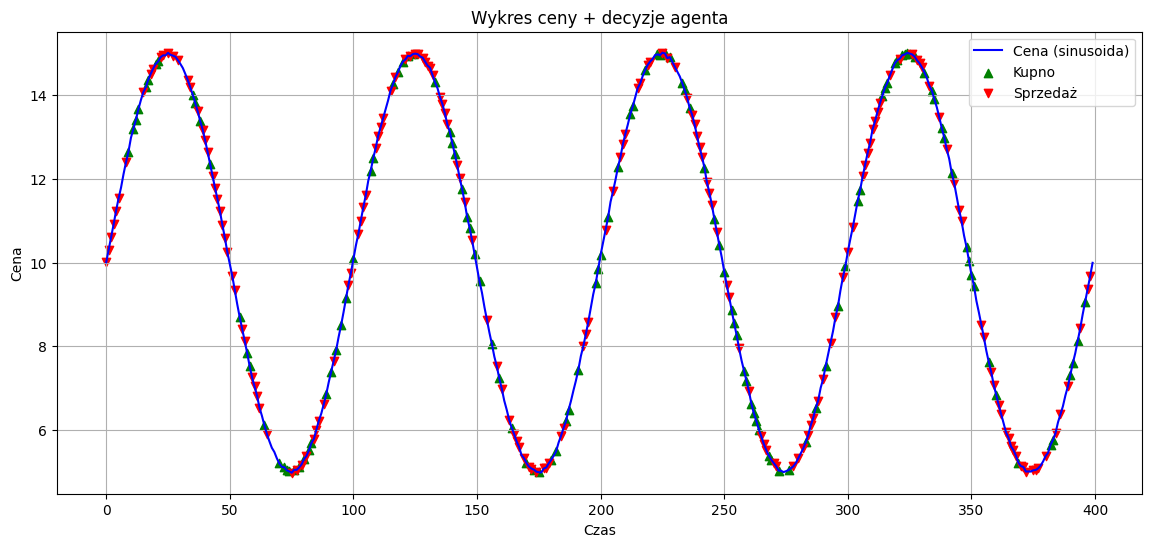

In [16]:
results_plot(env_predict=env_predict, prices=prices)